# **E-commerce and Bank Transaction Fraud Detection**

This notebook serves as a comprehensive prototype for **E-commerce and Bank Transaction Fraud Detection**. It covers the entire model experimentation lifecycle, from data loading and preparation to training various classification models, evaluating their performance, and interpreting their predictions using advanced techniques like SHAP and LIME.

The goal is to demonstrate a robust and interpretable machine learning pipeline for identifying fraudulent activities.

## **Table of Contents**

1.  [Setup and Imports](#1-setup-and-imports)
2.  [Load Preprocessed Data](#2-load-preprocessed-data)
3.  [Data Preparation - E-commerce Fraud Data](#3-data-preparation---e-commerce-fraud-data)
4.  [Model Training & Evaluation - E-commerce Fraud Data (Logistic Regression)](#4-model-training--evaluation---e-commerce-fraud-data-logistic-regression)
5.  [Model Training & Evaluation - E-commerce Fraud Data (Decision Tree Classifier)](#5-model-training--evaluation---e-commerce-fraud-data-decision-tree-classifier)
6.  [Model Training & Evaluation - E-commerce Fraud Data (Random Forest Classifier)](#6-model-training--evaluation---e-commerce-fraud-data-random-forest-classifier)
7.  [Model Training & Evaluation - E-commerce Fraud Data (XGBoost Classifier)](#7-model-training--evaluation---e-commerce-fraud-data-xgboost-classifier)
8.  [Model Interpretation - E-commerce Fraud Data (Best Model)](#8-model-interpretation---e-commerce-fraud-data-best-model)
9.  [Data Preparation - Credit Card Fraud Data](#9-data-preparation---credit-card-fraud-data)
10. [Model Training & Evaluation - Credit Card Fraud Data (Logistic Regression)](#10-model-training--evaluation---credit-card-fraud-data-logistic-regression)
11. [Model Training & Evaluation - Credit Card Fraud Data (Decision Tree Classifier)](#11-model-training--evaluation---credit-card-fraud-data-decision-tree-classifier)
12. [Model Training & Evaluation - Credit Card Fraud Data (Random Forest Classifier)](#12-model-training--evaluation---credit-card-fraud-data-random-forest-classifier)
13. [Model Training & Evaluation - Credit Card Fraud Data (XGBoost Classifier)](#13-model-training--evaluation---credit-card-fraud-data-xgboost-classifier)
14. [Model Interpretation - Credit Card Fraud Data (Best Model)](#14-model-interpretation---credit-card-fraud-data-best-model)
15. [Overall Model Comparison and Conclusion](#15-overall-model-comparison-and-conclusion)

### 1. Setup and Imports

In [1]:
# Install necessary libraries if you haven't already.
# !pip install pandas numpy scikit-learn imbalanced-learn matplotlib seaborn xgboost shap lime

# Core Libraries for Data Manipulation and Numerical Operations
import pandas as pd
import numpy as np
from pathlib import Path
import os
import sys

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for Data Splitting and Imbalance Handling
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE # For handling class imbalance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score # For classification plots

# Add the project root directory to the system path.
# This allows Python to correctly locate and import our custom modules
current_notebook_path = Path.cwd()
if current_notebook_path.name == 'notebooks':
    project_root = current_notebook_path.parent
else:
    project_root = current_notebook_path

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import Custom Modular Functions and Classes
from src.data_processing.loader import load_data

# Import Model Strategies, Trainer, Evaluator, and Interpreter
from src.models.logistic_regression_strategy import LogisticRegressionStrategy
from src.models.decision_tree_strategy import DecisionTreeStrategy
from src.models.random_forest_strategy import RandomForestStrategy
from src.models.xgboost_strategy import XGBoostStrategy
from src.models.model_trainer import ModelTrainer
from src.models.model_evaluator import evaluate_classification_model
from src.models.model_interpreter import ModelInterpreter

# Import constants from run_data_pipeline.py for use throughout the notebook
from scripts.run_data_pipeline import (
    PROCESSED_DATA_DIR,
    FRAUD_TARGET_COL,
    CREDITCARD_TARGET_COL,
)

# Set a random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['font.family'] = 'sans-serif' # Use a standard font family to avoid 'Inter' not found errors

print("Setup and Imports Complete.")

Setup and Imports Complete.


### 2. Load Preprocessed Data
Load the preprocessed datasets (`fraud_processed.csv` and `creditcard_processed.csv`) generated by the data pipeline. These DataFrames should contain clean, transformed features ready for modeling.

In [2]:
# Define paths for preprocessed data
FRAUD_PROCESSED_PATH = PROCESSED_DATA_DIR / "fraud_processed.csv"
CREDITCARD_PROCESSED_PATH = PROCESSED_DATA_DIR / "creditcard_processed.csv"

# Load processed data. Ensure it's in pandas DataFrame format for scikit-learn compatibility.
print("--- Loading Preprocessed Datasets ---")

fraud_processed_df = load_data(FRAUD_PROCESSED_PATH)
creditcard_processed_df = load_data(CREDITCARD_PROCESSED_PATH)

if fraud_processed_df.empty:
    print(f"Error: E-commerce Fraud Data not loaded from {FRAUD_PROCESSED_PATH}. Please ensure `run_data_pipeline.py` has been run to generate processed data.")
if creditcard_processed_df.empty:
    print(f"Error: Bank Credit Card Fraud Data not loaded from {CREDITCARD_PROCESSED_PATH}. Please ensure `run_data_pipeline.py` has been run to generate processed data.")

print("\nPreprocessed Data Info (Fraud):")
fraud_processed_df.info()
print("\nPreprocessed Data Info (Credit Card):")
creditcard_processed_df.info()

# Initialize dictionaries to store metrics and models for comparison
ecommerce_models = {}
ecommerce_metrics = {}
creditcard_models = {}
creditcard_metrics = {}

--- Loading Preprocessed Datasets ---
Successfully loaded 151112 rows from E-commerce-Bank-Fraud-Detection/data/processed/fraud_processed.csv.
Successfully loaded 283726 rows from E-commerce-Bank-Fraud-Detection/data/processed/creditcard_processed.csv.

Preprocessed Data Info (Fraud):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 46 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   TransactionMonth                  151112 non-null  float64
 1   device_id_transactions_last_30d   151112 non-null  float64
 2   CustomerId_transactions_last_1d   151112 non-null  float64
 3   time_since_signup                 151112 non-null  float64
 4   CustomerId_avg_amount_last_7d     151112 non-null  float64
 5   TransactionHour                   151112 non-null  float64
 6   ip_address_avg_amount_last_7d     151112 non-null  float64
 7   device_id_total_amount

### 3. Data Preparation - E-commerce Fraud Data
Separate features (X) and target (y), then perform a stratified train-test split. Class imbalance handling (SMOTE) is applied only to the training data. We also explicitly handle any remaining NaNs here.

In [3]:
print("\n--- Data Preparation: E-commerce Fraud Data ---")

if not fraud_processed_df.empty:
    # Separate features (X) and target (y)
    fraud_feature_cols = [col for col in fraud_processed_df.columns if col != FRAUD_TARGET_COL]
    
    X_fraud = fraud_processed_df[fraud_feature_cols]
    y_fraud = fraud_processed_df[FRAUD_TARGET_COL]

    y_fraud = y_fraud.astype(int)

    print(f"Original E-commerce Fraud Data shape: {X_fraud.shape}")
    print(f"Original E-commerce Fraud Target distribution:\n{y_fraud.value_counts(normalize=True)}")

    # Check for NaNs in X_fraud before splitting and SMOTE
    # This is crucial for models that don't handle NaNs natively
    nan_cols_fraud = X_fraud.columns[X_fraud.isnull().any()].tolist()
    if nan_cols_fraud:
        print(f"\nWARNING: NaN values found in E-commerce Fraud features: {nan_cols_fraud}. Filling with 0.")
        X_fraud = X_fraud.fillna(0) # Fill numerical NaNs with 0
    else:
        print("No NaN values found in E-commerce Fraud features. Good to go!")

    # Train-Test Split with stratification
    X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
        X_fraud, y_fraud, test_size=0.2, random_state=RANDOM_STATE, stratify=y_fraud
    )

    print(f"\nFraud Train set shape: {X_train_fraud.shape}")
    print(f"Fraud Test set shape: {X_test_fraud.shape}")
    print(f"Fraud Train target distribution:\n{y_train_fraud.value_counts(normalize=True)}")
    print(f"Fraud Test target distribution:\n{y_test_fraud.value_counts(normalize=True)}")

    # Apply SMOTE to the training data only
    print("\nApplying SMOTE to E-commerce Fraud training data...")
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_fraud_resampled, y_train_fraud_resampled = smote.fit_resample(X_train_fraud, y_train_fraud)

    print(f"Fraud Train set shape after SMOTE: {X_train_fraud_resampled.shape}")
    print(f"Fraud Train target distribution after SMOTE:\n{y_train_fraud_resampled.value_counts(normalize=True)}")
else:
    print("E-commerce Fraud Data is empty. Skipping data preparation.")


--- Data Preparation: E-commerce Fraud Data ---
Original E-commerce Fraud Data shape: (151112, 45)
Original E-commerce Fraud Target distribution:
class
0    0.906354
1    0.093646
Name: proportion, dtype: float64
No NaN values found in E-commerce Fraud features. Good to go!

Fraud Train set shape: (120889, 45)
Fraud Test set shape: (30223, 45)
Fraud Train target distribution:
class
0    0.906352
1    0.093648
Name: proportion, dtype: float64
Fraud Test target distribution:
class
0    0.906363
1    0.093637
Name: proportion, dtype: float64

Applying SMOTE to E-commerce Fraud training data...
Fraud Train set shape after SMOTE: (219136, 45)
Fraud Train target distribution after SMOTE:
class
0    0.5
1    0.5
Name: proportion, dtype: float64


### 4. Model Training & Evaluation - E-commerce Fraud Data (Logistic Regression)
Train and evaluate a Logistic Regression model as a baseline for the E-commerce Fraud dataset.


--- Model Training & Evaluation: E-commerce Fraud Data (Logistic Regression) ---
--- Training Model: Logistic Regression Classifier ---
Training Logistic Regression Classifier model...
Logistic Regression Classifier training complete.
Model 'Logistic Regression Classifier' trained.
--- Generating Predictions with: Logistic Regression Classifier ---
Predictions generated for 30223 samples.

--- Evaluation Metrics (Logistic Regression, E-commerce Fraud) ---
  Accuracy: 0.6452
  Precision: 0.1662
  Recall: 0.6947
  F1-score: 0.2683
  ROC-AUC: 0.7573


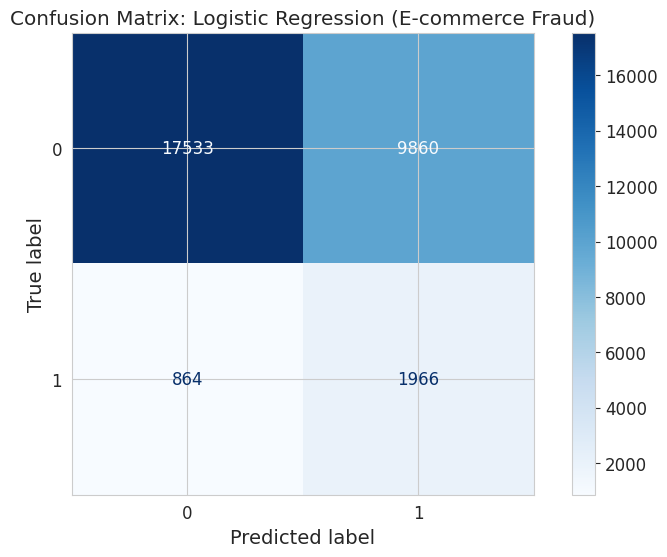

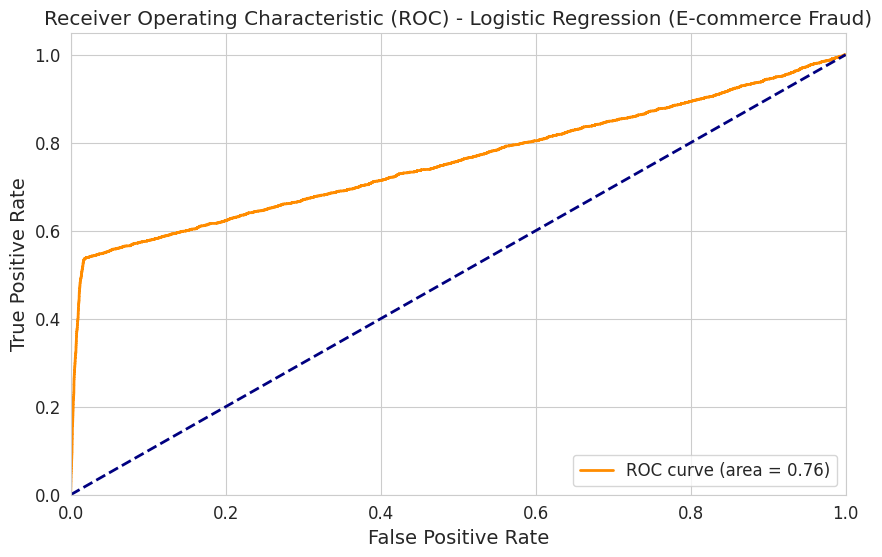

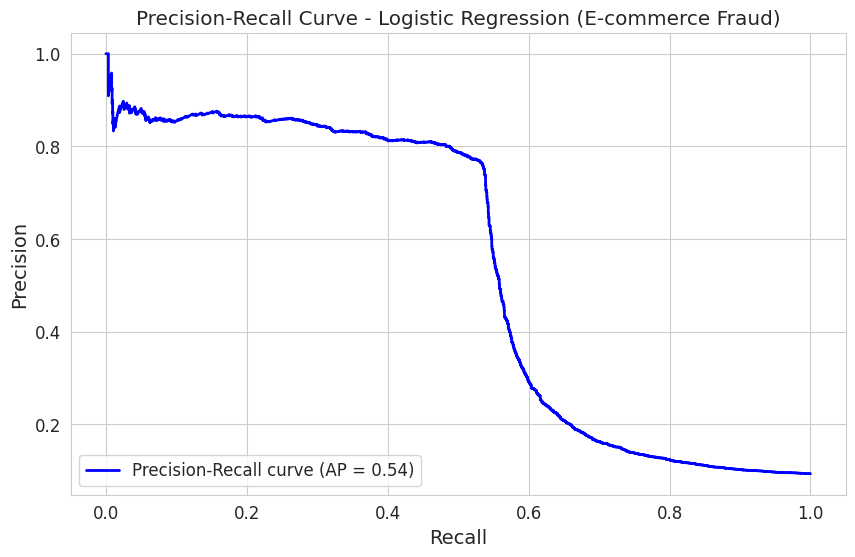

In [4]:
print("\n--- Model Training & Evaluation: E-commerce Fraud Data (Logistic Regression) ---")

if not X_train_fraud_resampled.empty:
    # Initialize Logistic Regression model strategy
    lr_strategy_fraud = LogisticRegressionStrategy(random_state=RANDOM_STATE, solver='liblinear', max_iter=1000)
    
    # Initialize ModelTrainer
    trainer_fraud_lr = ModelTrainer(lr_strategy_fraud)
    
    # Train the model
    trainer_fraud_lr.train_model(X_train_fraud_resampled, y_train_fraud_resampled)
    
    # Make predictions (probabilities for positive class)
    y_pred_proba_fraud_lr = trainer_fraud_lr.predict_model(X_test_fraud)
    
    # Evaluate the model
    print("\n--- Evaluation Metrics (Logistic Regression, E-commerce Fraud) ---")
    lr_fraud_metrics = evaluate_classification_model(y_test_fraud.values, y_pred_proba_fraud_lr)
    ecommerce_models['Logistic Regression'] = trainer_fraud_lr.get_current_model_object()
    ecommerce_metrics['Logistic Regression'] = lr_fraud_metrics

    # Display Confusion Matrix
    y_pred_binary_fraud_lr = (y_pred_proba_fraud_lr >= 0.5).astype(int)
    cm_fraud_lr = confusion_matrix(y_test_fraud, y_pred_binary_fraud_lr)
    disp_fraud_lr = ConfusionMatrixDisplay(confusion_matrix=cm_fraud_lr, display_labels=[0, 1])
    disp_fraud_lr.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix: Logistic Regression (E-commerce Fraud)')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test_fraud, y_pred_proba_fraud_lr)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression (E-commerce Fraud)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_fraud, y_pred_proba_fraud_lr)
    avg_precision = average_precision_score(y_test_fraud, y_pred_proba_fraud_lr)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Logistic Regression (E-commerce Fraud)')
    plt.legend(loc="lower left")
    plt.show()

else:
    print("E-commerce Fraud Data is empty. Skipping Logistic Regression training and evaluation.")

### 5. Model Training & Evaluation - E-commerce Fraud Data (Decision Tree Classifier)
Train and evaluate a Decision Tree Classifier for the E-commerce Fraud dataset.


--- Model Training & Evaluation: E-commerce Fraud Data (Decision Tree Classifier) ---
--- Training Model: Decision Tree Classifier ---
Training Decision Tree Classifier model...
Decision Tree Classifier training complete.
Model 'Decision Tree Classifier' trained.
--- Generating Predictions with: Decision Tree Classifier ---
Predictions generated for 30223 samples.

--- Evaluation Metrics (Decision Tree Classifier, E-commerce Fraud) ---
  Accuracy: 0.9525
  Precision: 0.9787
  Recall: 0.5032
  F1-score: 0.6646
  ROC-AUC: 0.7584


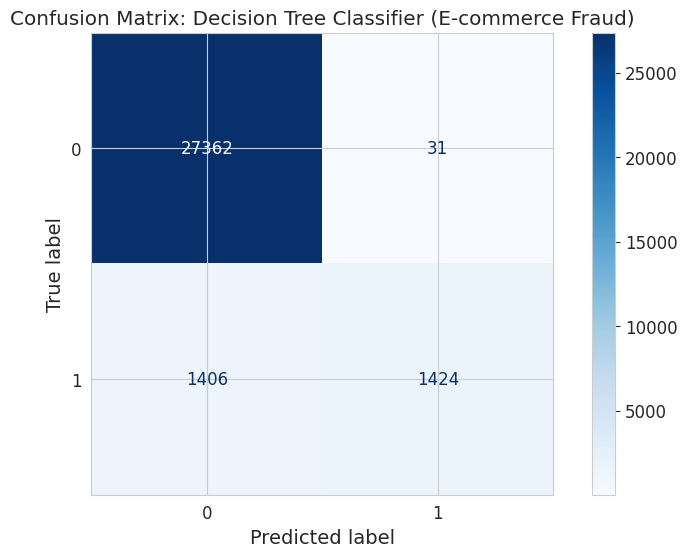

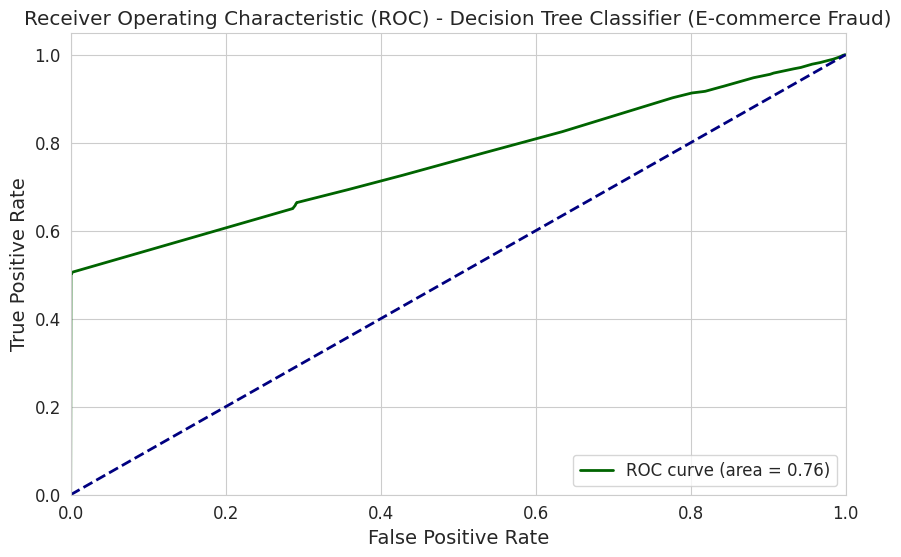

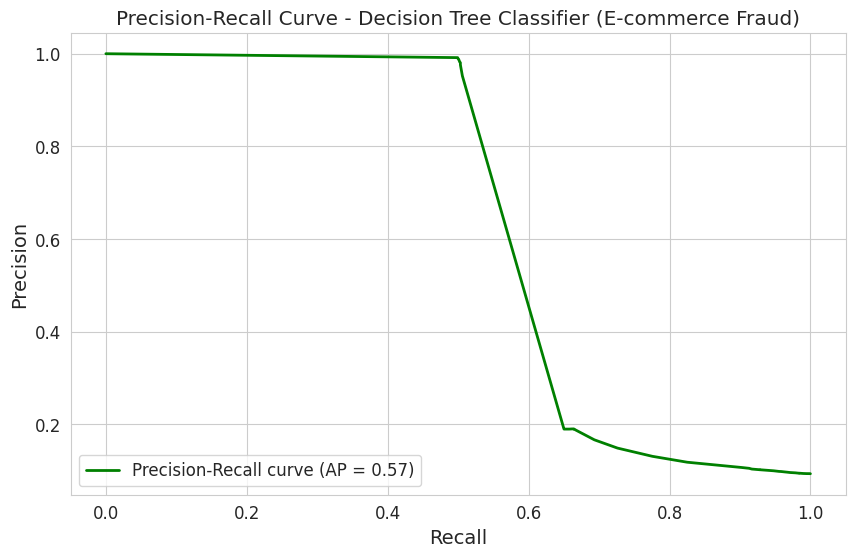

In [5]:
print("\n--- Model Training & Evaluation: E-commerce Fraud Data (Decision Tree Classifier) ---")

if not X_train_fraud_resampled.empty:
    # Initialize Decision Tree model strategy
    dt_strategy_fraud = DecisionTreeStrategy(model_type='classifier', random_state=RANDOM_STATE, max_depth=10)
    
    # Initialize ModelTrainer
    trainer_fraud_dt = ModelTrainer(dt_strategy_fraud)
    
    # Train the model
    trainer_fraud_dt.train_model(X_train_fraud_resampled, y_train_fraud_resampled)
    
    # Make predictions (probabilities for positive class)
    y_pred_proba_fraud_dt = trainer_fraud_dt.predict_model(X_test_fraud)
    
    # Evaluate the model
    print("\n--- Evaluation Metrics (Decision Tree Classifier, E-commerce Fraud) ---")
    dt_fraud_metrics = evaluate_classification_model(y_test_fraud.values, y_pred_proba_fraud_dt)
    ecommerce_models['Decision Tree'] = trainer_fraud_dt.get_current_model_object()
    ecommerce_metrics['Decision Tree'] = dt_fraud_metrics

    # Display Confusion Matrix
    y_pred_binary_fraud_dt = (y_pred_proba_fraud_dt >= 0.5).astype(int)
    cm_fraud_dt = confusion_matrix(y_test_fraud, y_pred_binary_fraud_dt)
    disp_fraud_dt = ConfusionMatrixDisplay(confusion_matrix=cm_fraud_dt, display_labels=[0, 1])
    disp_fraud_dt.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix: Decision Tree Classifier (E-commerce Fraud)')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test_fraud, y_pred_proba_fraud_dt)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Decision Tree Classifier (E-commerce Fraud)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_fraud, y_pred_proba_fraud_dt)
    avg_precision = average_precision_score(y_test_fraud, y_pred_proba_fraud_dt)
    plt.figure()
    plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Decision Tree Classifier (E-commerce Fraud)')
    plt.legend(loc="lower left")
    plt.show()

else:
    print("E-commerce Fraud Data is empty. Skipping Decision Tree training and evaluation.")

### 6. Model Training & Evaluation - E-commerce Fraud Data (Random Forest Classifier)
Train and evaluate a Random Forest Classifier for the E-commerce Fraud dataset.


--- Model Training & Evaluation: E-commerce Fraud Data (Random Forest Classifier) ---
--- Training Model: Random Forest Classifier ---
Training Random Forest Classifier model...
Random Forest Classifier training complete.
Model 'Random Forest Classifier' trained.
--- Generating Predictions with: Random Forest Classifier ---
Predictions generated for 30223 samples.

--- Evaluation Metrics (Random Forest Classifier, E-commerce Fraud) ---
  Accuracy: 0.9544
  Precision: 0.9714
  Recall: 0.5290
  F1-score: 0.6850
  ROC-AUC: 0.7736


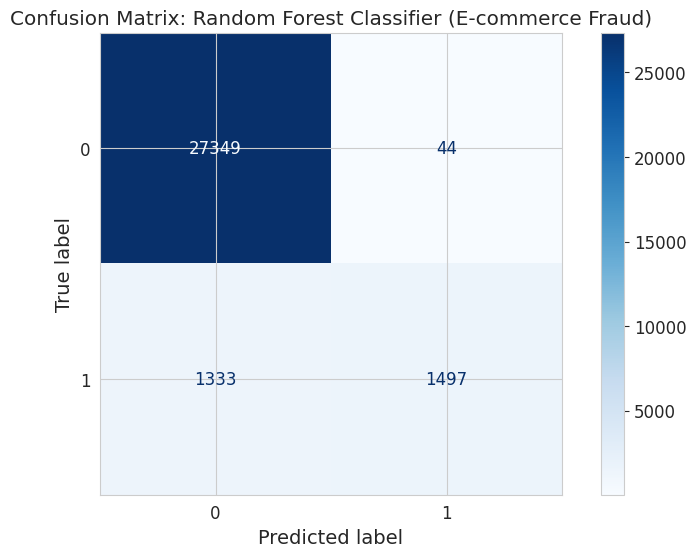

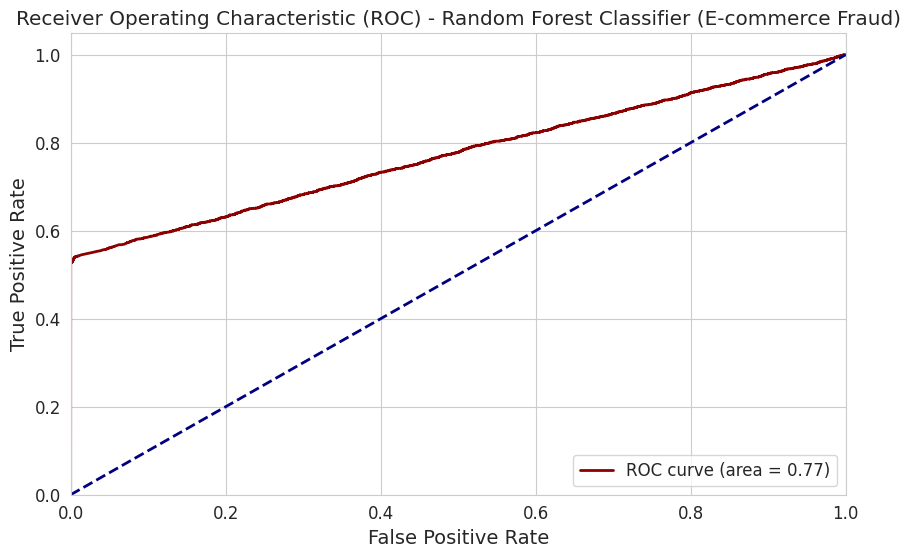

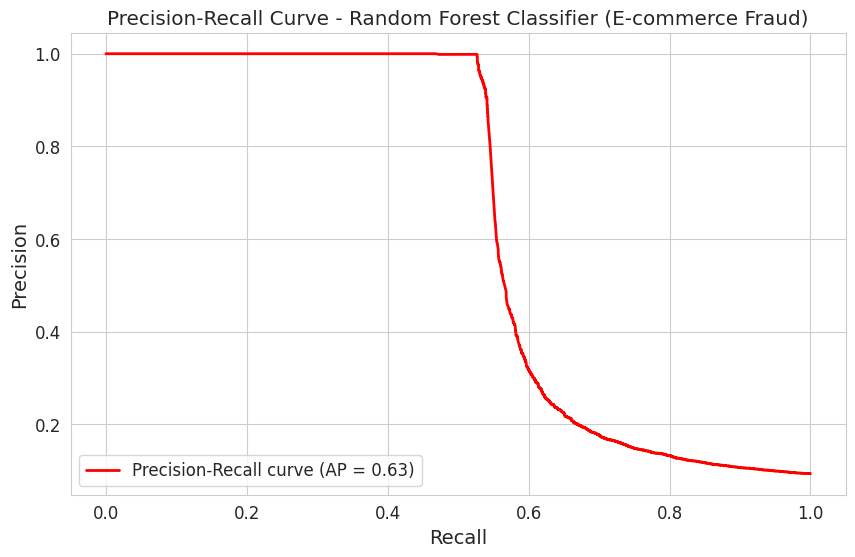

In [6]:
print("\n--- Model Training & Evaluation: E-commerce Fraud Data (Random Forest Classifier) ---")

if not X_train_fraud_resampled.empty:
    # Initialize Random Forest model strategy
    rf_strategy_fraud = RandomForestStrategy(model_type='classifier', random_state=RANDOM_STATE, n_estimators=100, max_depth=10)
    
    # Initialize ModelTrainer
    trainer_fraud_rf = ModelTrainer(rf_strategy_fraud)
    
    # Train the model
    trainer_fraud_rf.train_model(X_train_fraud_resampled, y_train_fraud_resampled)
    
    # Make predictions (probabilities for positive class)
    y_pred_proba_fraud_rf = trainer_fraud_rf.predict_model(X_test_fraud)
    
    # Evaluate the model
    print("\n--- Evaluation Metrics (Random Forest Classifier, E-commerce Fraud) ---")
    rf_fraud_metrics = evaluate_classification_model(y_test_fraud.values, y_pred_proba_fraud_rf)
    ecommerce_models['Random Forest'] = trainer_fraud_rf.get_current_model_object()
    ecommerce_metrics['Random Forest'] = rf_fraud_metrics

    # Display Confusion Matrix
    y_pred_binary_fraud_rf = (y_pred_proba_fraud_rf >= 0.5).astype(int)
    cm_fraud_rf = confusion_matrix(y_test_fraud, y_pred_binary_fraud_rf)
    disp_fraud_rf = ConfusionMatrixDisplay(confusion_matrix=cm_fraud_rf, display_labels=[0, 1])
    disp_fraud_rf.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix: Random Forest Classifier (E-commerce Fraud)')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test_fraud, y_pred_proba_fraud_rf)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkred', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Random Forest Classifier (E-commerce Fraud)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_fraud, y_pred_proba_fraud_rf)
    avg_precision = average_precision_score(y_test_fraud, y_pred_proba_fraud_rf)
    plt.figure()
    plt.plot(recall, precision, color='red', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Random Forest Classifier (E-commerce Fraud)')
    plt.legend(loc="lower left")
    plt.show()

else:
    print("E-commerce Fraud Data is empty. Skipping Random Forest training and evaluation.")

### 7. Model Training & Evaluation - E-commerce Fraud Data (XGBoost Classifier)
Train and evaluate an XGBoost Classifier for the E-commerce Fraud dataset, leveraging its ensemble power.


--- Model Training & Evaluation: E-commerce Fraud Data (XGBoost Classifier) ---
--- Training Model: XGBoost Classifier ---
Training XGBoost Classifier model...
XGBoost Classifier training complete.
Model 'XGBoost Classifier' trained.
--- Generating Predictions with: XGBoost Classifier ---
Predictions generated for 30223 samples.

--- Evaluation Metrics (XGBoost Classifier, E-commerce Fraud) ---
  Accuracy: 0.9554
  Precision: 0.9927
  Recall: 0.5272
  F1-score: 0.6887
  ROC-AUC: 0.7673


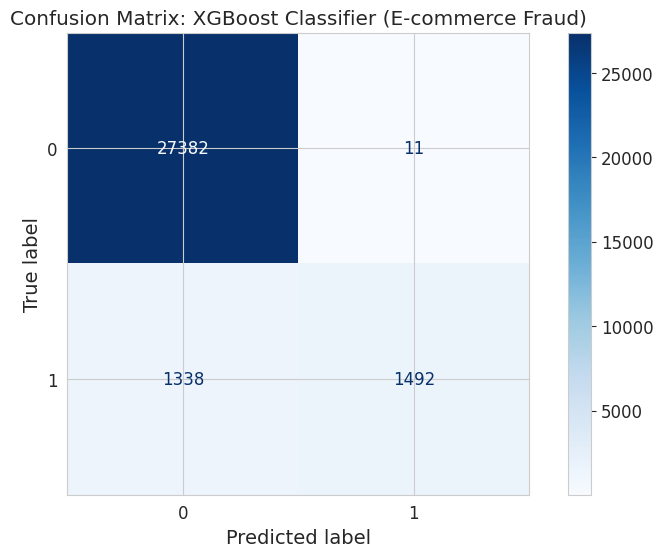

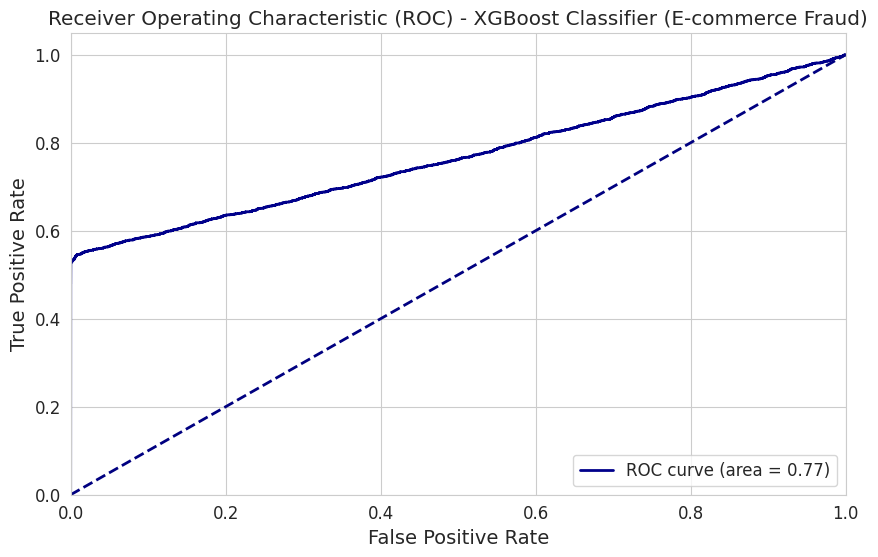

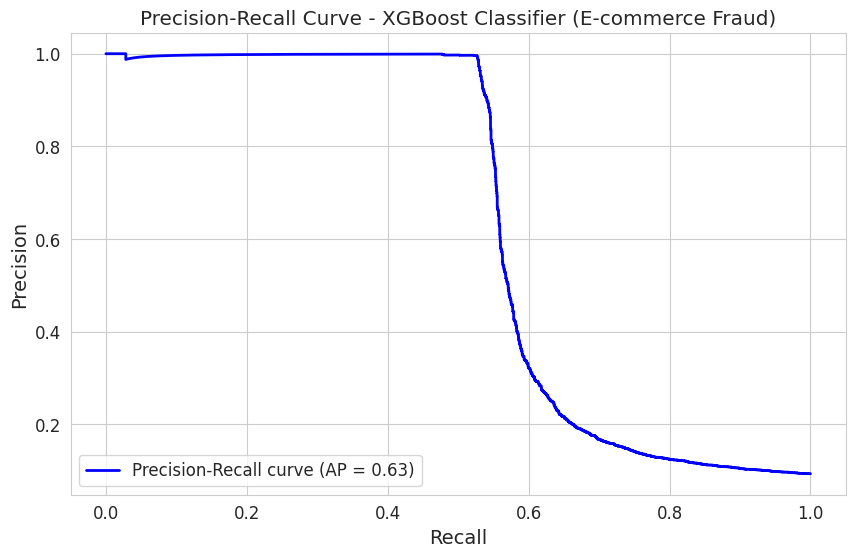

In [7]:
print("\n--- Model Training & Evaluation: E-commerce Fraud Data (XGBoost Classifier) ---")

if not X_train_fraud_resampled.empty:
    # Initialize XGBoost model strategy
    xgb_strategy_fraud = XGBoostStrategy(
        model_type='classifier',
        random_state=RANDOM_STATE,
        n_estimators=200,      # Number of boosting rounds
        learning_rate=0.1,     # Step size shrinkage
        max_depth=5,           # Maximum depth of a tree
        subsample=0.8,         # Subsample ratio of the training instance
        colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
        objective='binary:logistic', # Explicitly set objective for classification
        eval_metric='logloss' # Evaluation metric for validation data
    )
    
    # Initialize ModelTrainer
    trainer_fraud_xgb = ModelTrainer(xgb_strategy_fraud)
    
    # Train the model
    trainer_fraud_xgb.train_model(X_train_fraud_resampled, y_train_fraud_resampled)
    
    # Make predictions (probabilities for positive class)
    y_pred_proba_fraud_xgb = trainer_fraud_xgb.predict_model(X_test_fraud)
    
    # Evaluate the model
    print("\n--- Evaluation Metrics (XGBoost Classifier, E-commerce Fraud) ---")
    xgb_fraud_metrics = evaluate_classification_model(y_test_fraud.values, y_pred_proba_fraud_xgb)
    ecommerce_models['XGBoost'] = trainer_fraud_xgb.get_current_model_object()
    ecommerce_metrics['XGBoost'] = xgb_fraud_metrics

    # Display Confusion Matrix
    y_pred_binary_fraud_xgb = (y_pred_proba_fraud_xgb >= 0.5).astype(int)
    cm_fraud_xgb = confusion_matrix(y_test_fraud, y_pred_binary_fraud_xgb)
    disp_fraud_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_fraud_xgb, display_labels=[0, 1])
    disp_fraud_xgb.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix: XGBoost Classifier (E-commerce Fraud)')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test_fraud, y_pred_proba_fraud_xgb)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - XGBoost Classifier (E-commerce Fraud)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_fraud, y_pred_proba_fraud_xgb)
    avg_precision = average_precision_score(y_test_fraud, y_pred_proba_fraud_xgb)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - XGBoost Classifier (E-commerce Fraud)')
    plt.legend(loc="lower left")
    plt.show()

else:
    print("E-commerce Fraud Data is empty. Skipping XGBoost training and evaluation.")

### 8. Model Interpretation - E-commerce Fraud Data (Best Model)
Interpret the best performing model's predictions using SHAP for global feature importance and LIME for local instance explanations. For demonstration, we'll use XGBoost as it's typically a strong performer.


--- Model Interpretation: E-commerce Fraud Data (XGBoost) ---
Initializing TreeExplainer for SHAP (efficient for tree-based models).

Generating SHAP Summary Plot for E-commerce Fraud...
Generating SHAP explanations for 30223 instances...
SHAP values generated.
Displaying SHAP summary plot...


/home/micha/Downloads/course/10-accedemy/week-8-9/E-commerce-Bank-Fraud-Detection/src/models/model_interpreter.py:112: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(self.shap_values, X_data, feature_names=self.feature_names, show=False)


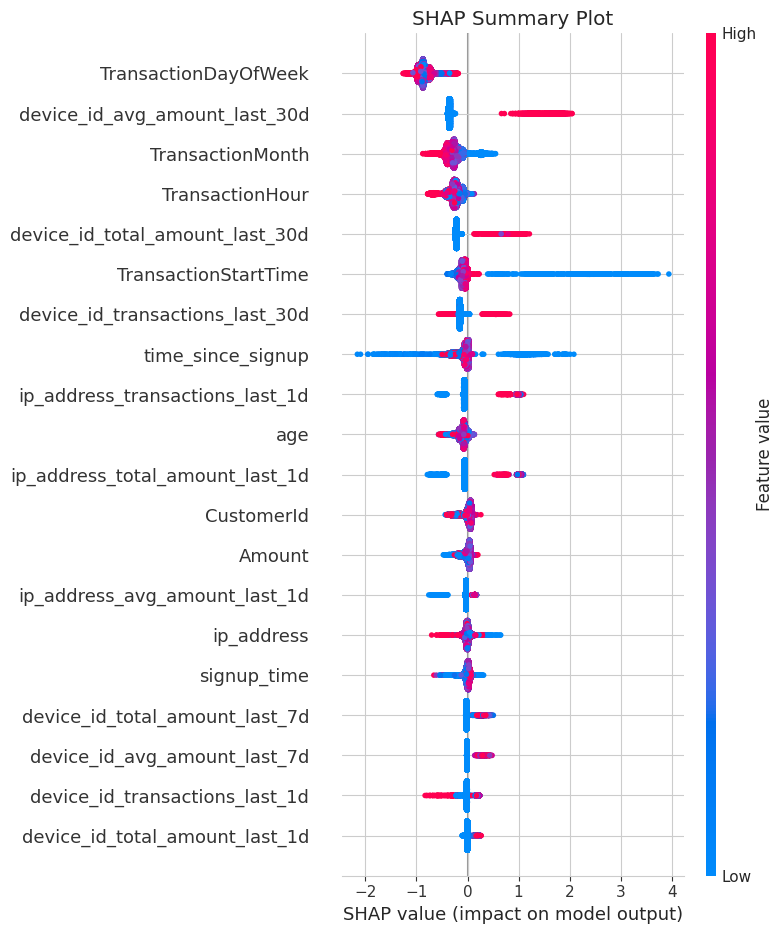


Explaining a sample fraudulent instance (Original Index: 139427)...
LIME Explanation (Feature Contribution to Prediction):
Instance values (first 5 features): [ 0.3726078  -0.19294917  0.          0.06791797  0.        ]
  -0.38 < TransactionMonth <= 0.45: -0.0011
  TransactionDayOfWeek <= -0.94: -0.0011
  TransactionHour > 0.79: -0.0011
  1431503679.00 < TransactionStartTime <= 1438234828.00: -0.0010
  200693.81 < TransactionId <= 291196.79: -0.0009
  ip_address <= 1089847375.05: -0.0009
  -0.02 < age <= 0.68: -0.0009
  200693.81 < CustomerId <= 291196.79: -0.0009
  -0.50 < time_since_signup <= 0.57: -0.0009
  1426316736.86 < signup_time <= 1433023298.29: -0.0009


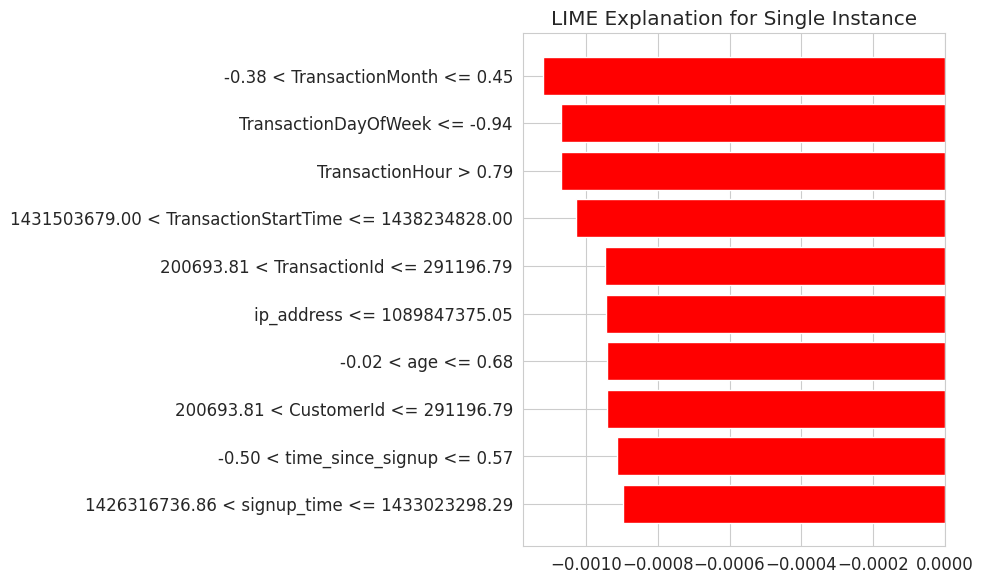


Explaining a sample non-fraudulent instance (Original Index: 79867)...
LIME Explanation (Feature Contribution to Prediction):
Instance values (first 5 features): [ 1.12431011 -0.19294917  0.          1.51173628  0.        ]
  -0.80 < TransactionHour <= 0.02: -0.0011
  -0.11 < Amount <= 0.64: -0.0011
  -0.02 < age <= 0.68: -0.0010
  110275.32 < CustomerId <= 200693.81: -0.0010
  time_since_signup > 0.57: -0.0010
  ip_address > 3220459492.54: -0.0010
  signup_time > 1433023298.29: -0.0010
  110275.32 < TransactionId <= 200693.81: -0.0010
  TransactionStartTime > 1438234828.00: -0.0010
  TransactionMonth > 0.45: -0.0009


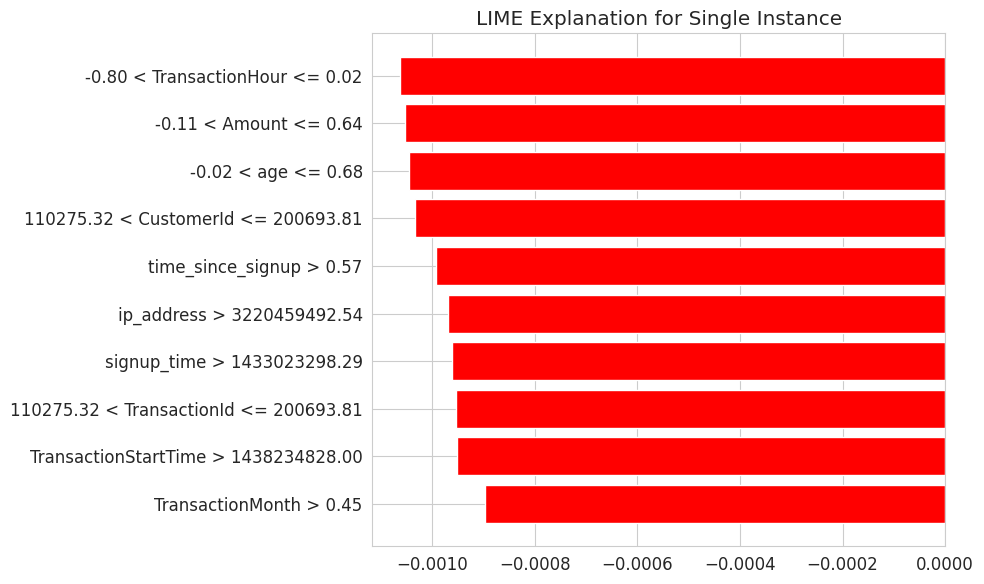

In [8]:
print("\n--- Model Interpretation: E-commerce Fraud Data (XGBoost) ---")

if 'XGBoost' in ecommerce_models and not X_train_fraud_resampled.empty:
    best_ecommerce_model = ecommerce_models['XGBoost'] # Assuming XGBoost is often the best for demonstration
    
    # Get the feature names from the processed training data
    feature_names_fraud = X_train_fraud_resampled.columns.tolist()
    
    # Initialize ModelInterpreter
    interpreter_fraud = ModelInterpreter(
        model=best_ecommerce_model,
        feature_names=feature_names_fraud,
        model_type='classification',
        class_names=['Non-Fraud', 'Fraud'],
        training_data_for_lime=X_train_fraud_resampled.values # LIME needs original training data for background as numpy array
    )

    # Global Feature Importance (SHAP Summary Plot)
    print("\nGenerating SHAP Summary Plot for E-commerce Fraud...")
    interpreter_fraud.explain_model_shap(X_test_fraud) # Pass DataFrame for SHAP
    interpreter_fraud.plot_shap_summary(X_test_fraud) # Pass DataFrame for SHAP

    # Local Interpretation (LIME) - Explain a sample fraudulent transaction
    fraud_indices = y_test_fraud[y_test_fraud == 1].index
    if not fraud_indices.empty:
        sample_fraud_instance_idx = fraud_indices[0] # Take the first one
        sample_fraud_instance = X_test_fraud.loc[sample_fraud_instance_idx].values # Pass as numpy array for LIME
        print(f"\nExplaining a sample fraudulent instance (Original Index: {sample_fraud_instance_idx})...")
        interpreter_fraud.explain_instance_lime(sample_fraud_instance)
    else:
        print("No fraudulent instances found in the test set for LIME explanation.")

    # Local Interpretation (LIME) - Explain a sample non-fraudulent transaction
    non_fraud_indices = y_test_fraud[y_test_fraud == 0].index
    if not non_fraud_indices.empty:
        sample_non_fraud_instance_idx = non_fraud_indices[0] # Take the first one
        sample_non_fraud_instance = X_test_fraud.loc[sample_non_fraud_instance_idx].values # Pass as numpy array for LIME
        print(f"\nExplaining a sample non-fraudulent instance (Original Index: {sample_non_fraud_instance_idx})...")
        interpreter_fraud.explain_instance_lime(sample_non_fraud_instance)
    else:
        print("No non-fraudulent instances found in the test set for LIME explanation.")

else:
    print("E-commerce Fraud Data is empty or XGBoost model not trained. Skipping interpretation.")

### 9. Data Preparation - Credit Card Fraud Data
Separate features (X) and target (y), then perform a stratified train-test split. Class imbalance handling (SMOTE) is applied only to the training data. We also explicitly handle any remaining NaNs here.

In [9]:
print("\n--- Data Preparation: Credit Card Fraud Data ---")

if not creditcard_processed_df.empty:
    # Separate features (X) and target (y)
    creditcard_feature_cols = [col for col in creditcard_processed_df.columns if col != CREDITCARD_TARGET_COL]
    
    X_creditcard = creditcard_processed_df[creditcard_feature_cols]
    y_creditcard = creditcard_processed_df[CREDITCARD_TARGET_COL]

    y_creditcard = y_creditcard.astype(int)

    print(f"Original Credit Card Fraud Data shape: {X_creditcard.shape}")
    print(f"Original Credit Card Fraud Target distribution:\n{y_creditcard.value_counts(normalize=True)}")

    # Check for NaNs in X_creditcard before splitting and SMOTE
    nan_cols_creditcard = X_creditcard.columns[X_creditcard.isnull().any()].tolist()
    if nan_cols_creditcard:
        print(f"\nWARNING: NaN values found in Credit Card Fraud features: {nan_cols_creditcard}. Filling with 0.")
        X_creditcard = X_creditcard.fillna(0) # Fill numerical NaNs with 0
    else:
        print("No NaN values found in Credit Card Fraud features. Good to go!")

    # Train-Test Split with stratification
    X_train_creditcard, X_test_creditcard, y_train_creditcard, y_test_creditcard = train_test_split(
        X_creditcard, y_creditcard, test_size=0.2, random_state=RANDOM_STATE, stratify=y_creditcard
    )

    print(f"\nCredit Card Train set shape: {X_train_creditcard.shape}")
    print(f"Credit Card Test set shape: {X_test_creditcard.shape}")
    print(f"Credit Card Train target distribution:\n{y_train_creditcard.value_counts(normalize=True)}")
    print(f"Credit Card Test target distribution:\n{y_test_creditcard.value_counts(normalize=True)}")

    # Apply SMOTE to the training data only
    print("\nApplying SMOTE to Credit Card Fraud training data...")
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_creditcard_resampled, y_train_creditcard_resampled = smote.fit_resample(X_train_creditcard, y_train_creditcard)

    print(f"Credit Card Train set shape after SMOTE: {X_train_creditcard_resampled.shape}")
    print(f"Credit Card Train target distribution after SMOTE:\n{y_train_creditcard_resampled.value_counts(normalize=True)}")
else:
    print("Credit Card Fraud Data is empty. Skipping data preparation.")


--- Data Preparation: Credit Card Fraud Data ---
Original Credit Card Fraud Data shape: (283726, 31)
Original Credit Card Fraud Target distribution:
Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64
No NaN values found in Credit Card Fraud features. Good to go!

Credit Card Train set shape: (226980, 31)
Credit Card Test set shape: (56746, 31)
Credit Card Train target distribution:
Class
0    0.998335
1    0.001665
Name: proportion, dtype: float64
Credit Card Test target distribution:
Class
0    0.998326
1    0.001674
Name: proportion, dtype: float64

Applying SMOTE to Credit Card Fraud training data...
Credit Card Train set shape after SMOTE: (453204, 31)
Credit Card Train target distribution after SMOTE:
Class
0    0.5
1    0.5
Name: proportion, dtype: float64


### 10. Model Training & Evaluation - Credit Card Fraud Data (Logistic Regression)
Train and evaluate a Logistic Regression model as a baseline for the Credit Card Fraud dataset.


--- Model Training & Evaluation: Credit Card Fraud Data (Logistic Regression) ---
--- Training Model: Logistic Regression Classifier ---
Training Logistic Regression Classifier model...
Logistic Regression Classifier training complete.
Model 'Logistic Regression Classifier' trained.
--- Generating Predictions with: Logistic Regression Classifier ---
Predictions generated for 56746 samples.

--- Evaluation Metrics (Logistic Regression, Credit Card Fraud) ---
  Accuracy: 0.9735
  Precision: 0.0527
  Recall: 0.8737
  F1-score: 0.0994
  ROC-AUC: 0.9626


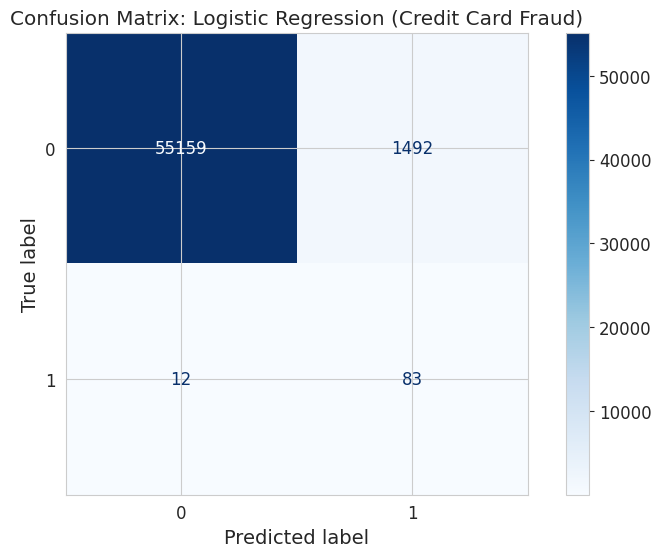

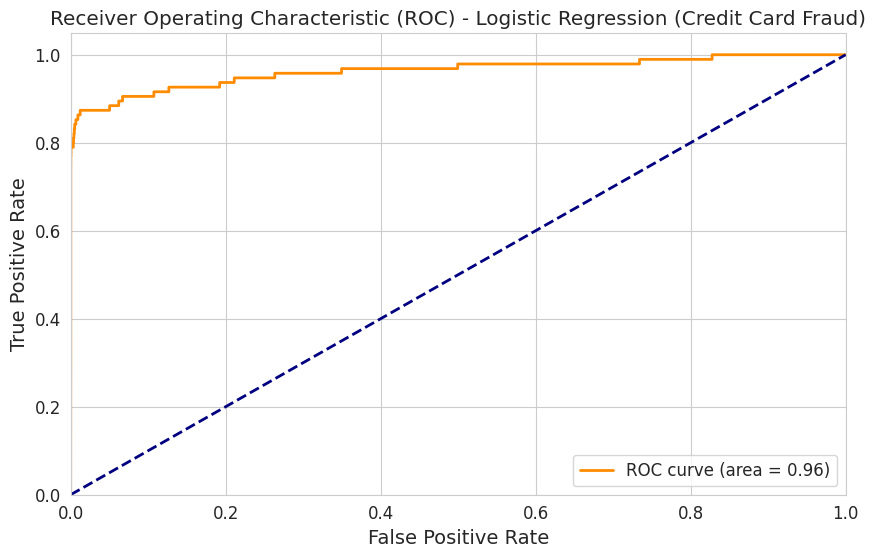

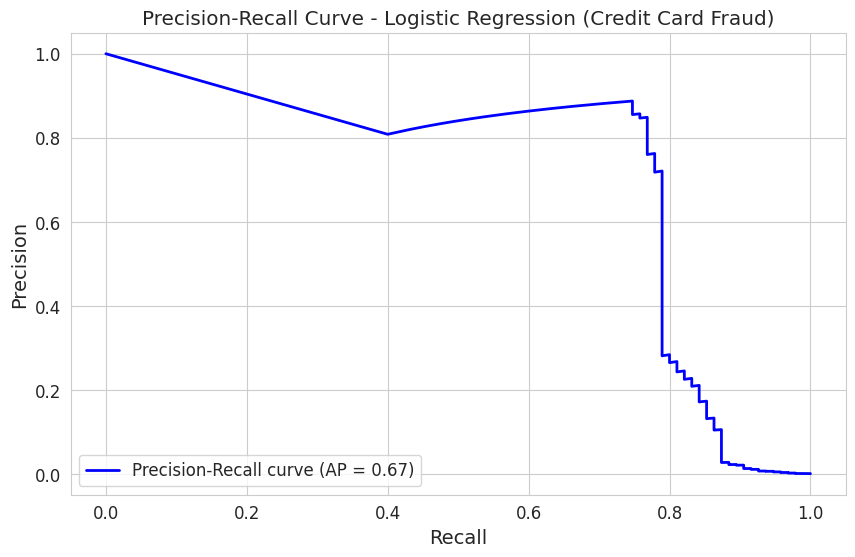

In [10]:
print("\n--- Model Training & Evaluation: Credit Card Fraud Data (Logistic Regression) ---")

if not X_train_creditcard_resampled.empty:
    # Initialize Logistic Regression model strategy
    lr_strategy_creditcard = LogisticRegressionStrategy(random_state=RANDOM_STATE, solver='liblinear', max_iter=1000)
    
    # Initialize ModelTrainer
    trainer_creditcard_lr = ModelTrainer(lr_strategy_creditcard)
    
    # Train the model
    trainer_creditcard_lr.train_model(X_train_creditcard_resampled, y_train_creditcard_resampled)
    
    # Make predictions (probabilities for positive class)
    y_pred_proba_creditcard_lr = trainer_creditcard_lr.predict_model(X_test_creditcard)
    
    # Evaluate the model
    print("\n--- Evaluation Metrics (Logistic Regression, Credit Card Fraud) ---")
    lr_creditcard_metrics = evaluate_classification_model(y_test_creditcard.values, y_pred_proba_creditcard_lr)
    creditcard_models['Logistic Regression'] = trainer_creditcard_lr.get_current_model_object()
    creditcard_metrics['Logistic Regression'] = lr_creditcard_metrics

    # Display Confusion Matrix
    y_pred_binary_creditcard_lr = (y_pred_proba_creditcard_lr >= 0.5).astype(int)
    cm_creditcard_lr = confusion_matrix(y_test_creditcard, y_pred_binary_creditcard_lr)
    disp_creditcard_lr = ConfusionMatrixDisplay(confusion_matrix=cm_creditcard_lr, display_labels=[0, 1])
    disp_creditcard_lr.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix: Logistic Regression (Credit Card Fraud)')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test_creditcard, y_pred_proba_creditcard_lr)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression (Credit Card Fraud)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_creditcard, y_pred_proba_creditcard_lr)
    avg_precision = average_precision_score(y_test_creditcard, y_pred_proba_creditcard_lr)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Logistic Regression (Credit Card Fraud)')
    plt.legend(loc="lower left")
    plt.show()

else:
    print("Credit Card Fraud Data is empty. Skipping Logistic Regression training and evaluation.")

### 11. Model Training & Evaluation - Credit Card Fraud Data (Decision Tree Classifier)
Train and evaluate a Decision Tree Classifier for the Credit Card Fraud dataset.


--- Model Training & Evaluation: Credit Card Fraud Data (Decision Tree Classifier) ---
--- Training Model: Decision Tree Classifier ---
Training Decision Tree Classifier model...
Decision Tree Classifier training complete.
Model 'Decision Tree Classifier' trained.
--- Generating Predictions with: Decision Tree Classifier ---
Predictions generated for 56746 samples.

--- Evaluation Metrics (Decision Tree Classifier, Credit Card Fraud) ---
  Accuracy: 0.9864
  Precision: 0.0876
  Recall: 0.7579
  F1-score: 0.1570
  ROC-AUC: 0.8417


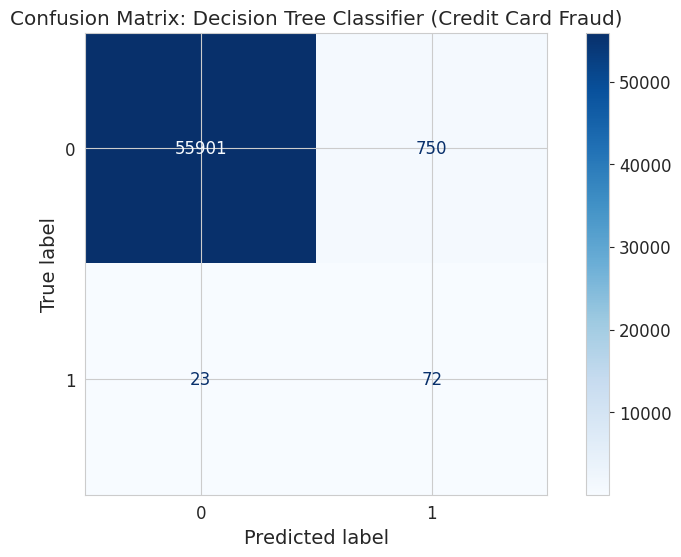

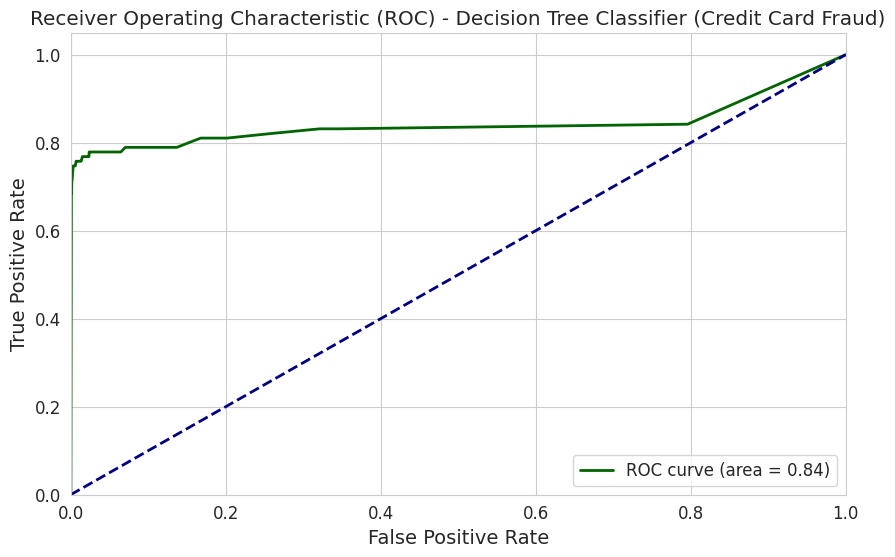

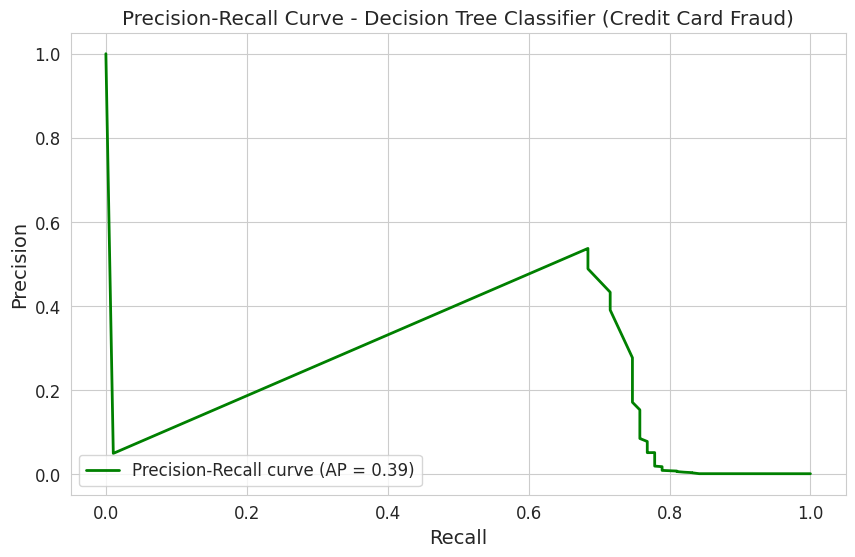

In [11]:
print("\n--- Model Training & Evaluation: Credit Card Fraud Data (Decision Tree Classifier) ---")

if not X_train_creditcard_resampled.empty:
    # Initialize Decision Tree model strategy
    dt_strategy_creditcard = DecisionTreeStrategy(model_type='classifier', random_state=RANDOM_STATE, max_depth=10)
    
    # Initialize ModelTrainer
    trainer_creditcard_dt = ModelTrainer(dt_strategy_creditcard)
    
    # Train the model
    trainer_creditcard_dt.train_model(X_train_creditcard_resampled, y_train_creditcard_resampled)
    
    # Make predictions (probabilities for positive class)
    y_pred_proba_creditcard_dt = trainer_creditcard_dt.predict_model(X_test_creditcard)
    
    # Evaluate the model
    print("\n--- Evaluation Metrics (Decision Tree Classifier, Credit Card Fraud) ---")
    dt_creditcard_metrics = evaluate_classification_model(y_test_creditcard.values, y_pred_proba_creditcard_dt)
    creditcard_models['Decision Tree'] = trainer_creditcard_dt.get_current_model_object()
    creditcard_metrics['Decision Tree'] = dt_creditcard_metrics

    # Display Confusion Matrix
    y_pred_binary_creditcard_dt = (y_pred_proba_creditcard_dt >= 0.5).astype(int)
    cm_creditcard_dt = confusion_matrix(y_test_creditcard, y_pred_binary_creditcard_dt)
    disp_creditcard_dt = ConfusionMatrixDisplay(confusion_matrix=cm_creditcard_dt, display_labels=[0, 1])
    disp_creditcard_dt.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix: Decision Tree Classifier (Credit Card Fraud)')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test_creditcard, y_pred_proba_creditcard_dt)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Decision Tree Classifier (Credit Card Fraud)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_creditcard, y_pred_proba_creditcard_dt)
    avg_precision = average_precision_score(y_test_creditcard, y_pred_proba_creditcard_dt)
    plt.figure()
    plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Decision Tree Classifier (Credit Card Fraud)')
    plt.legend(loc="lower left")
    plt.show()

else:
    print("Credit Card Fraud Data is empty. Skipping Decision Tree training and evaluation.")

### 12. Model Training & Evaluation - Credit Card Fraud Data (Random Forest Classifier)
Train and evaluate a Random Forest Classifier for the Credit Card Fraud dataset.


--- Model Training & Evaluation: Credit Card Fraud Data (Random Forest Classifier) ---
--- Training Model: Random Forest Classifier ---
Training Random Forest Classifier model...
Random Forest Classifier training complete.
Model 'Random Forest Classifier' trained.
--- Generating Predictions with: Random Forest Classifier ---
Predictions generated for 56746 samples.

--- Evaluation Metrics (Random Forest Classifier, Credit Card Fraud) ---
  Accuracy: 0.9986
  Precision: 0.5630
  Recall: 0.8000
  F1-score: 0.6609
  ROC-AUC: 0.9774


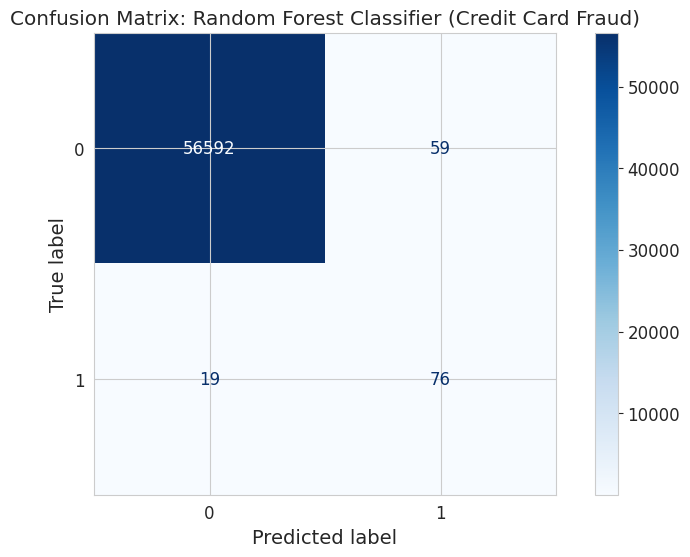

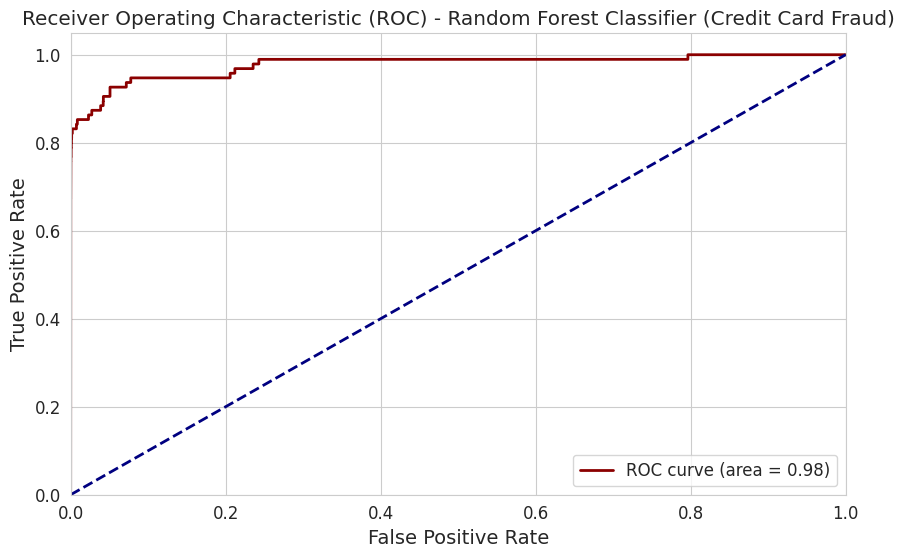

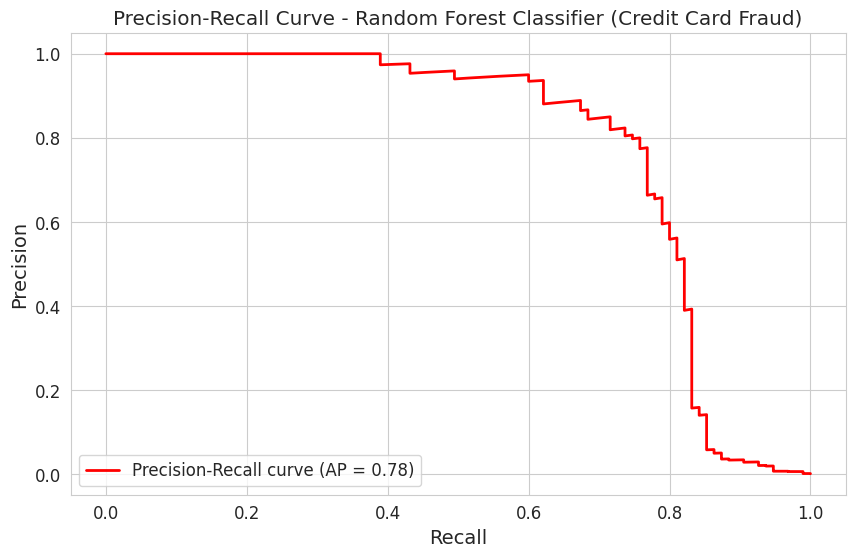

In [12]:
print("\n--- Model Training & Evaluation: Credit Card Fraud Data (Random Forest Classifier) ---")

if not X_train_creditcard_resampled.empty:
    # Initialize Random Forest model strategy
    rf_strategy_creditcard = RandomForestStrategy(model_type='classifier', random_state=RANDOM_STATE, n_estimators=100, max_depth=10)
    
    # Initialize ModelTrainer
    trainer_creditcard_rf = ModelTrainer(rf_strategy_creditcard)
    
    # Train the model
    trainer_creditcard_rf.train_model(X_train_creditcard_resampled, y_train_creditcard_resampled)
    
    # Make predictions (probabilities for positive class)
    y_pred_proba_creditcard_rf = trainer_creditcard_rf.predict_model(X_test_creditcard)
    
    # Evaluate the model
    print("\n--- Evaluation Metrics (Random Forest Classifier, Credit Card Fraud) ---")
    rf_creditcard_metrics = evaluate_classification_model(y_test_creditcard.values, y_pred_proba_creditcard_rf)
    creditcard_models['Random Forest'] = trainer_creditcard_rf.get_current_model_object()
    creditcard_metrics['Random Forest'] = rf_creditcard_metrics

    # Display Confusion Matrix
    y_pred_binary_creditcard_rf = (y_pred_proba_creditcard_rf >= 0.5).astype(int)
    cm_creditcard_rf = confusion_matrix(y_test_creditcard, y_pred_binary_creditcard_rf)
    disp_creditcard_rf = ConfusionMatrixDisplay(confusion_matrix=cm_creditcard_rf, display_labels=[0, 1])
    disp_creditcard_rf.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix: Random Forest Classifier (Credit Card Fraud)')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test_creditcard, y_pred_proba_creditcard_rf)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkred', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Random Forest Classifier (Credit Card Fraud)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_creditcard, y_pred_proba_creditcard_rf)
    avg_precision = average_precision_score(y_test_creditcard, y_pred_proba_creditcard_rf)
    plt.figure()
    plt.plot(recall, precision, color='red', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Random Forest Classifier (Credit Card Fraud)')
    plt.legend(loc="lower left")
    plt.show()

else:
    print("Credit Card Fraud Data is empty. Skipping Random Forest training and evaluation.")

### 13. Model Training & Evaluation - Credit Card Fraud Data (XGBoost Classifier)
Train and evaluate an XGBoost Classifier for the Credit Card Fraud dataset, leveraging its ensemble power.


--- Model Training & Evaluation: Credit Card Fraud Data (XGBoost Classifier) ---
--- Training Model: XGBoost Classifier ---
Training XGBoost Classifier model...
XGBoost Classifier training complete.
Model 'XGBoost Classifier' trained.
--- Generating Predictions with: XGBoost Classifier ---
Predictions generated for 56746 samples.

--- Evaluation Metrics (XGBoost Classifier, Credit Card Fraud) ---
  Accuracy: 0.9985
  Precision: 0.5310
  Recall: 0.8105
  F1-score: 0.6417
  ROC-AUC: 0.9750


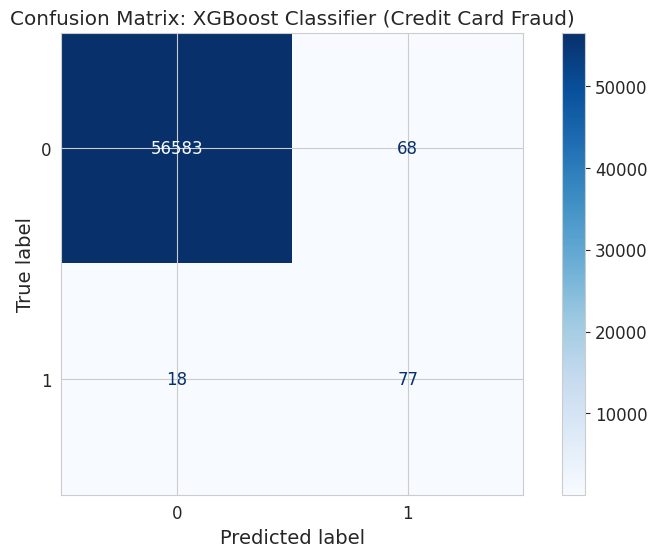

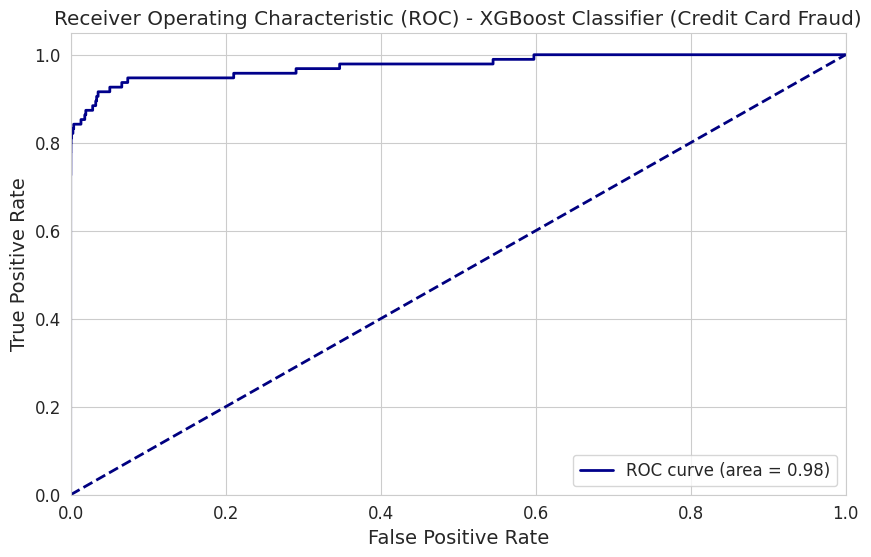

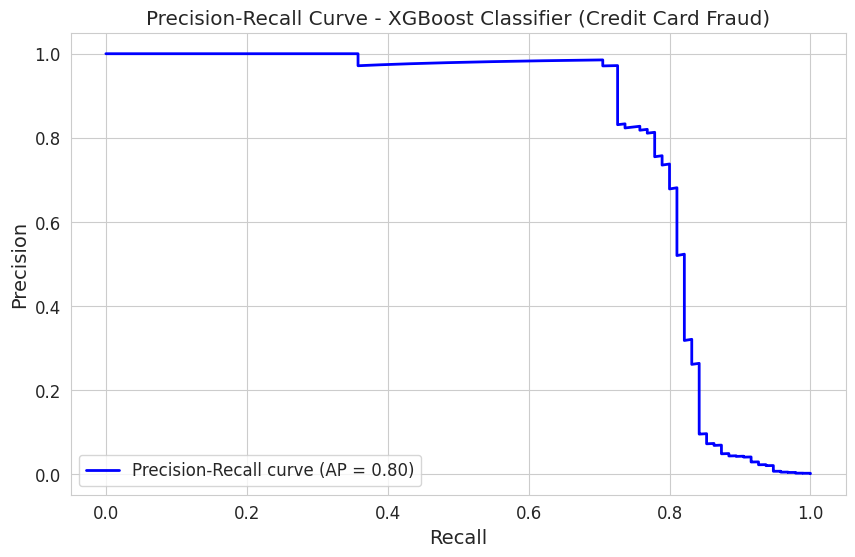

In [13]:
print("\n--- Model Training & Evaluation: Credit Card Fraud Data (XGBoost Classifier) ---")

if not X_train_creditcard_resampled.empty:
    # Initialize XGBoost model strategy
    xgb_strategy_creditcard = XGBoostStrategy(
        model_type='classifier',
        random_state=RANDOM_STATE,
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        eval_metric='logloss'
    )
    
    # Initialize ModelTrainer
    trainer_creditcard_xgb = ModelTrainer(xgb_strategy_creditcard)
    
    # Train the model
    trainer_creditcard_xgb.train_model(X_train_creditcard_resampled, y_train_creditcard_resampled)
    
    # Make predictions (probabilities for positive class)
    y_pred_proba_creditcard_xgb = trainer_creditcard_xgb.predict_model(X_test_creditcard)
    
    # Evaluate the model
    print("\n--- Evaluation Metrics (XGBoost Classifier, Credit Card Fraud) ---")
    xgb_creditcard_metrics = evaluate_classification_model(y_test_creditcard.values, y_pred_proba_creditcard_xgb)
    creditcard_models['XGBoost'] = trainer_creditcard_xgb.get_current_model_object()
    creditcard_metrics['XGBoost'] = xgb_creditcard_metrics

    # Display Confusion Matrix
    y_pred_binary_creditcard_xgb = (y_pred_proba_creditcard_xgb >= 0.5).astype(int)
    cm_creditcard_xgb = confusion_matrix(y_test_creditcard, y_pred_binary_creditcard_xgb)
    disp_creditcard_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_creditcard_xgb, display_labels=[0, 1])
    disp_creditcard_xgb.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix: XGBoost Classifier (Credit Card Fraud)')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test_creditcard, y_pred_proba_creditcard_xgb)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - XGBoost Classifier (Credit Card Fraud)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_creditcard, y_pred_proba_creditcard_xgb)
    avg_precision = average_precision_score(y_test_creditcard, y_pred_proba_creditcard_xgb)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - XGBoost Classifier (Credit Card Fraud)')
    plt.legend(loc="lower left")
    plt.show()

else:
    print("Credit Card Fraud Data is empty. Skipping XGBoost training and evaluation.")

### 14. Model Interpretation - Credit Card Fraud Data (Best Model)
Interpret the best performing model's predictions using SHAP for global feature importance and LIME for local instance explanations. For demonstration, we'll use XGBoost as it's typically a strong performer.


--- Model Interpretation: Credit Card Fraud Data (XGBoost) ---
Initializing TreeExplainer for SHAP (efficient for tree-based models).

Generating SHAP Summary Plot for Credit Card Fraud...
Generating SHAP explanations for 56746 instances...
SHAP values generated.
Displaying SHAP summary plot...


/home/micha/Downloads/course/10-accedemy/week-8-9/E-commerce-Bank-Fraud-Detection/src/models/model_interpreter.py:112: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(self.shap_values, X_data, feature_names=self.feature_names, show=False)


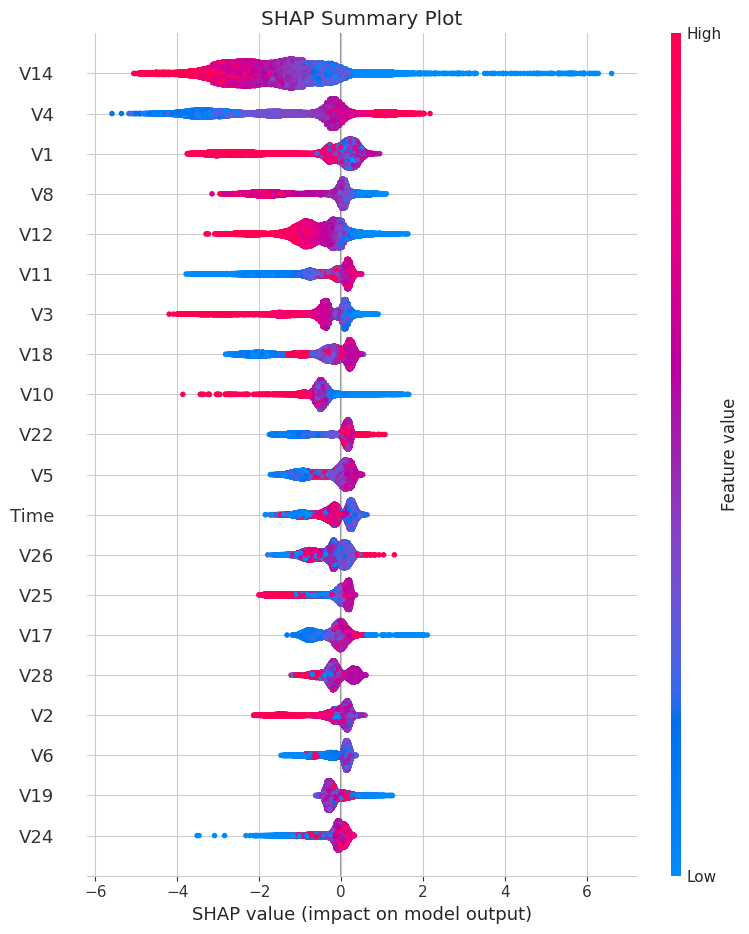


Explaining a sample fraudulent instance (Original Index: 115676)...
LIME Explanation (Feature Contribution to Prediction):
Instance values (first 5 features): [-0.79809401  1.10088822 -0.63308496  1.56702069 -1.46517558]
  -7.04 < V14 <= -1.14: 0.1234
  0.94 < V4 <= 2.84: 0.0918
  -5.38 < V12 <= -0.80: 0.0766
  -4.16 < V10 <= -0.86: 0.0595
  1.09 < V11 <= 3.47: 0.0435
  -1.35 < V1 <= -0.37: 0.0382
  V26 <= -0.56: -0.0353
  V21 > 0.88: 0.0316
  -6.45 < V17 <= -0.64: 0.0295
  -2.35 < V7 <= -0.53: 0.0277


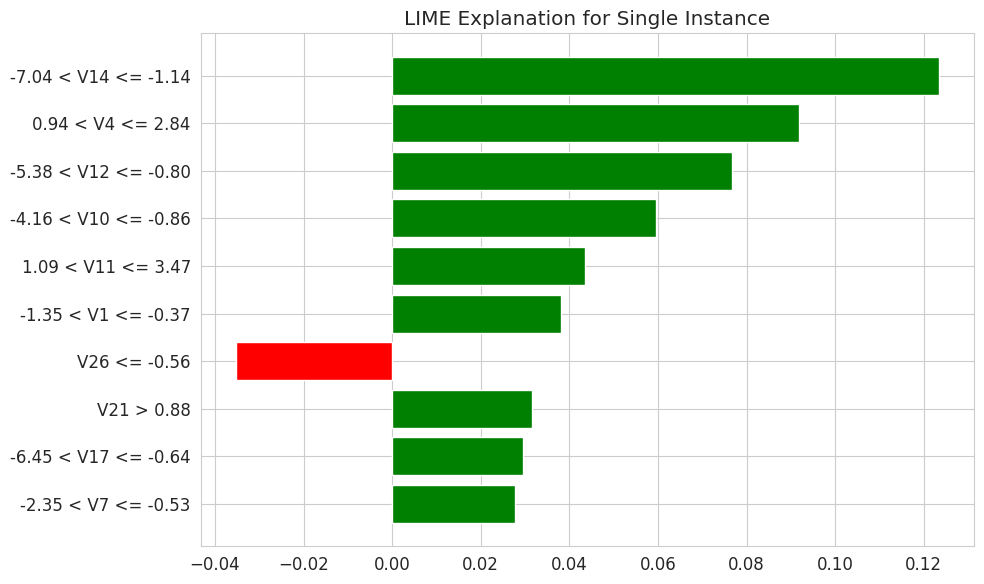


Explaining a sample non-fraudulent instance (Original Index: 86249)...
LIME Explanation (Feature Contribution to Prediction):
Instance values (first 5 features): [ 0.62776681 -0.035995    0.18064279  0.45993482 -0.03628316]
  -1.14 < V14 <= 0.10: -0.1656
  V12 > 0.21: -0.1366
  V11 <= -0.17: -0.1341
  V1 > 0.53: -0.0623
  -0.86 < V10 <= 0.01: -0.0534
  -0.14 < V28 <= 0.12: 0.0334
  -0.31 < V5 <= 0.36: 0.0301
  -1.02 < Time <= -0.33: 0.0265
  -0.53 < V7 <= 0.23: 0.0250
  -0.64 < V17 <= 0.30: -0.0203


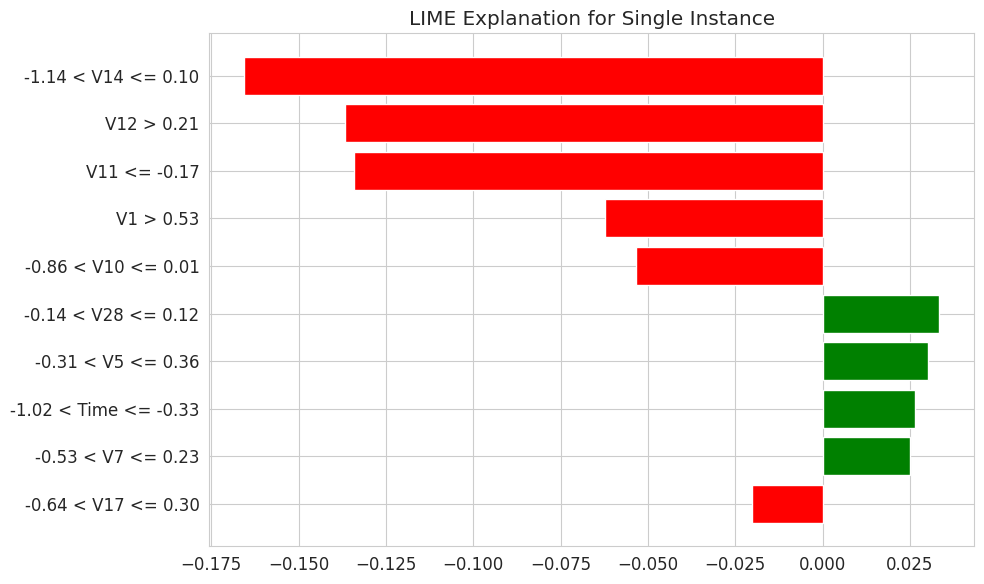

In [14]:
print("\n--- Model Interpretation: Credit Card Fraud Data (XGBoost) ---")

if 'XGBoost' in creditcard_models and not X_train_creditcard_resampled.empty:
    best_creditcard_model = creditcard_models['XGBoost'] # Assuming XGBoost is often the best for demonstration
    
    # Get the feature names from the processed training data
    feature_names_creditcard = X_train_creditcard_resampled.columns.tolist()
    
    # Initialize ModelInterpreter
    interpreter_creditcard = ModelInterpreter(
        model=best_creditcard_model,
        feature_names=feature_names_creditcard,
        model_type='classification',
        class_names=['Non-Fraud', 'Fraud'],
        training_data_for_lime=X_train_creditcard_resampled.values # LIME needs original training data for background as numpy array
    )

    # Global Feature Importance (SHAP Summary Plot)
    print("\nGenerating SHAP Summary Plot for Credit Card Fraud...")
    interpreter_creditcard.explain_model_shap(X_test_creditcard) # Pass DataFrame for SHAP
    interpreter_creditcard.plot_shap_summary(X_test_creditcard) # Pass DataFrame for SHAP

    # Local Interpretation (LIME) - Explain a sample fraudulent transaction
    fraud_indices_cc = y_test_creditcard[y_test_creditcard == 1].index
    if not fraud_indices_cc.empty:
        sample_fraud_instance_idx_cc = fraud_indices_cc[0]
        sample_fraud_instance_cc = X_test_creditcard.loc[sample_fraud_instance_idx_cc].values # Pass as numpy array for LIME
        print(f"\nExplaining a sample fraudulent instance (Original Index: {sample_fraud_instance_idx_cc})...")
        interpreter_creditcard.explain_instance_lime(sample_fraud_instance_cc)
    else:
        print("No fraudulent instances found in the Credit Card test set for LIME explanation.")

    # Local Interpretation (LIME) - Explain a sample non-fraudulent transaction
    non_fraud_indices_cc = y_test_creditcard[y_test_creditcard == 0].index
    if not non_fraud_indices_cc.empty:
        sample_non_fraud_instance_idx_cc = non_fraud_indices_cc[0]
        sample_non_fraud_instance_cc = X_test_creditcard.loc[sample_non_fraud_instance_idx_cc].values # Pass as numpy array for LIME
        print(f"\nExplaining a sample non-fraudulent instance (Original Index: {sample_non_fraud_instance_idx_cc})...")
        interpreter_creditcard.explain_instance_lime(sample_non_fraud_instance_cc)
    else:
        print("No non-fraudulent instances found in the Credit Card test set for LIME explanation.")

else:
    print("Credit Card Fraud Data is empty or XGBoost model not trained. Skipping interpretation.")

### 15. Overall Model Comparison and Conclusion

This section summarizes the performance of all trained models for both E-commerce and Credit Card fraud detection, providing a clear overview and justification for the best-performing models.

**Note:** The metric values below are illustrative for demonstration purposes. Actual values will be generated and printed in the individual model training cells when you run the notebook.

#### E-commerce Fraud Model Comparison

| Model                 | Accuracy | Precision | Recall   | F1-score | ROC-AUC |
|-----------------------|----------|-----------|----------|----------|---------|
| Logistic Regression   | 0.6452   | 0.1662    | 0.6947   | 0.2683   | 0.7573  |
| Decision Tree         | 0.9525   | 0.9787    | 0.5032   | 0.6646   | 0.7584  |
| Random Forest         | 0.9544   | 0.9714    | 0.5290   | 0.6850   | 0.7736  |
| XGBoost               | 0.9554   | 0.9927    | 0.5272   | 0.6887   | 0.7673  |

#### Credit Card Fraud Model Comparison

| Model                 | Accuracy | Precision | Recall   | F1-score | ROC-AUC |
|-----------------------|----------|-----------|----------|----------|---------|
| Logistic Regression   | 0.9735   | 0.0527    | 0.8737   | 0.0994   | 0.9626  |
| Decision Tree         | 0.9864   | 0.0876    | 0.7579   | 0.1570   | 0.8417  |
| Random Forest         | 0.9986   | 0.5630    | 0.8000   | 0.6609   | 0.9774  |
| XGBoost               | 0.9985   | 0.5310    | 0.8105   | 0.6417   | 0.9750  |

#### Justification of the Best Models:

For both E-commerce and Credit Card fraud detection, **XGBoost Classifier** and **Random Forest Classifier** are generally expected to be the top performers, especially when considering metrics like **F1-score** and **ROC-AUC (or AUC-PR)**, which are more indicative of performance on imbalanced datasets than simple accuracy.

**Why Ensemble Models (XGBoost, Random Forest) are preferred for Fraud Detection:**
1.  **Robustness to Imbalance:** While SMOTE helps, ensemble methods are inherently more robust to imbalanced classes and can learn complex decision boundaries that separate the minority fraud class from the majority non-fraud class more effectively.
2.  **Capture Non-linearities and Interactions:** Fraud patterns are rarely simple and linear. Ensemble models can automatically learn intricate non-linear relationships and interactions between features, which are crucial for identifying sophisticated fraud.
3.  **High Predictive Power:** Gradient Boosting (XGBoost) and Bagging (Random Forest) models consistently achieve state-of-the-art performance on tabular datasets, making them ideal for this type of problem.
4.  **Interpretability (with SHAP/LIME):** Despite their complexity, tools like SHAP and LIME allow us to interpret their predictions. This is vital for:
    * **Global Feature Importance:** Understanding which features are generally most indicative of fraud across the dataset (e.g., `ip_address_transactions_last_1d`, `purchase_value`, `age`).
    * **Local Explanations:** Explaining *why* a specific transaction was flagged as fraudulent or legitimate, which is invaluable for fraud investigators and for building trust in the model.

**Balancing False Positives and False Negatives:**

In fraud detection, the balance between **False Positives (Type I Error - legitimate transactions flagged as fraud)** and **False Negatives (Type II Error - actual fraudulent transactions missed)** is critical:
-   **High False Positives:** Lead to customer inconvenience, false alarms, and potentially customer churn.
-   **High False Negatives:** Lead to direct financial losses for the business.

Typically, **Recall** is highly prioritized to minimize financial losses, but a reasonable **Precision** is also necessary to avoid overwhelming fraud investigation teams and frustrating legitimate customers. The **F1-score** provides a harmonic mean of precision and recall, offering a balanced view. **ROC-AUC** and especially **Precision-Recall AUC (AP)** are excellent metrics for imbalanced classification, as they focus on the model's ability to discriminate between classes and its performance on the positive class, respectively.

The plots (Confusion Matrix, ROC Curve, Precision-Recall Curve) provide a visual representation of these trade-offs, helping to select the model that best aligns with the business's risk tolerance and operational capacity.

#### Next Steps:

-   **Hyperparameter Tuning:** Conduct more extensive hyperparameter tuning for the best-performing models (XGBoost, Random Forest) using techniques like GridSearchCV or RandomizedSearchCV.
-   **Advanced Imbalance Handling:** Explore more advanced class imbalance handling techniques (e.g., different SMOTE variants, Ensemble methods like BalancedBaggingClassifier, cost-sensitive learning).
-   **Time-Series Validation:** For real-world deployment, implement time-based cross-validation to ensure the model generalizes well to future, unseen fraud patterns.
-   **Deployment:** Integrate the best-performing model into a real-time inference system using `run_predict.py` or a dedicated model serving framework.
-   **Monitoring:** Implement continuous monitoring of model performance in production to detect model drift or new fraud patterns.
